# 00 INSTALLING DEPENDENCIES

In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 13.6 MB/s 
     |████████████████████████████████| 145 kB 15.4 MB/s 
     |████████████████████████████████| 74 kB 4.1 MB/s 
     |████████████████████████████████| 112 kB 69.4 MB/s 
     |████████████████████████████████| 596 kB 67.0 MB/s 


In [3]:
import torch
from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

#import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
import time

## 01 LOADING MODELNET DATASET
The ModelNet10/40 datasets from the “3D ShapeNets: A Deep Representation for Volumetric Shapes” paper, containing CAD models of 10 and 40 categories, respectively.

In [4]:
dataset = ModelNet("\..", pre_transform = T.FaceToEdge(remove_faces=True))

Extracting \../ModelNet10.zip
Processing...
Done!


In [5]:
dataset

ModelNet10(3991)

In [6]:
# Investigating the dataset
print("Dataset type: ", type(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print("Dataset sample: ", dataset[0])
print("Sample  nodes: ", dataset[0].num_nodes)
print("Sample  edges: ", dataset[0].num_edges)


Dataset type:  <class 'torch_geometric.datasets.modelnet.ModelNet'>
Dataset features:  0
Dataset target:  10
Dataset length:  <bound method InMemoryDataset.len of ModelNet10(3991)>
Dataset sample:  Data(pos=[1118, 3], y=[1], edge_index=[2, 4644])
Sample  nodes:  1118
Sample  edges:  4644


In [7]:
cats = {}
for d in dataset:
  
  cat = d.y.numpy()[0]
  if cat not in cats:
    cats[cat] = 1
  else:
    cats[cat] +=1


In [8]:
count_df = pd.DataFrame.from_dict(cats,orient = 'index').transpose()

In [10]:
count_df

,0,1,2,3,4,5,6,7,8,9
0,106,515,889,200,200,465,200,680,392,344


Text(0.5, 1.0, 'ModelNet10 Classes')

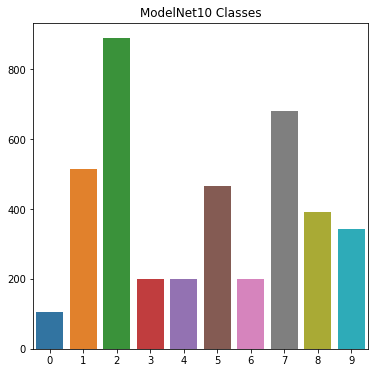

In [11]:
###count of classes
plt.figure(figsize=(6,6))
ax = sns.barplot(data=count_df)
plt.title('ModelNet10 Classes')

In [12]:
features_count = []
cats = [] 
for d in dataset:
  feat = d.pos.numpy().ravel()
  cat = d.y.numpy()[0]
  #print(feat.shape[0])
  features_count.append(feat.shape[0])
  cats.append(cat)

In [13]:
df_feat = pd.DataFrame([cats,features_count])
df_f = df_feat.rename(index={0: "categories", 1: "feature size"}).transpose()

In [14]:
df_f

,categories,feature size
0,0,3354
1,0,2280
2,0,55593
3,0,53751
4,0,9339
...,...,...
3986,9,1638
3987,9,34587
3988,9,1437
3989,9,1584


Text(0.5, 1.0, 'ModelNet10 Feature sizes')

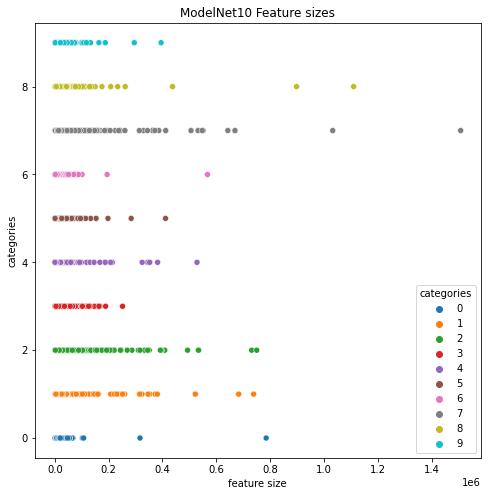

In [15]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_f, x="feature size", y="categories", hue="categories", palette="tab10")
plt.title('ModelNet10 Feature sizes')

In [16]:
dataset[1]

Data(pos=[760, 3], y=[1], edge_index=[2, 3034])

In [17]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
dataset[0].x

In [18]:
data_size = len(dataset)
data_size

3991

In [19]:
num_features = dataset.num_features
num_classes = dataset.num_classes

print(num_classes, num_features)

10 0


## 02 CREATING NEURAL NETWORK
GCN = GRAPH CONVOLUTION NETWORK FOR CLASSIFICATION
TAKES AS INPUT
 
Data(pos=[21578, 3], y=[1], edge_index=[2, 106820])
where pos = points locations, y = class, edge_index = how vertices are connected by indices

In [20]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import time


class GCN(torch.nn.Module):
    def __init__(self, num_features, embedding_size=64):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output layer
        self.out = Linear(embedding_size*2, num_classes)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden


In [21]:

model = GCN(num_features)
print(model)
#print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(0, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


## 03 LOAD DATA INTO DATALOADER TORCH

In [27]:
from google.colab import drive
#@title 1.2 Prepare Folders
#@markdown If you connect your Google Drive, you can save the final image of each run on your drive.

google_drive = True #@param {type:"boolean"}

#@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
yes_please = True #@param {type:"boolean"}

if google_drive is True:
  drive.mount('/content/drive')
 
else:
  root_path = '/content'

Mounted at /content/drive


In [22]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Cross EntrophyLoss
lr = 0.0007
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Wrap data in a data loader
data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 64


loader = DataLoader(dataset[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(dataset[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



In [23]:
dataset[1000]

Data(pos=[2844, 3], y=[1], edge_index=[2, 13428])

## 04 TRAINING MODEL

In [ ]:
def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.pos, batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding
print("Starting training...")
losses = []
start_time = time.time()
for epoch in range(500):
    loss, h = train(dataset)
    losses.append(loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")
end_time = time.time()
total_time = end_time - start_time
print(total_time,lr )

Starting training...
Epoch 0 | Train Loss 0.07061601430177689
Epoch 10 | Train Loss 0.027305355295538902
Epoch 20 | Train Loss 0.027365390211343765
Epoch 30 | Train Loss 0.23644545674324036
Epoch 40 | Train Loss 0.028360577300190926
Epoch 50 | Train Loss 0.041830893605947495
Epoch 60 | Train Loss 0.012157851830124855
Epoch 70 | Train Loss 0.01881999522447586
Epoch 80 | Train Loss 0.026638206094503403
Epoch 90 | Train Loss 0.21419787406921387
Epoch 100 | Train Loss 0.014073668047785759
Epoch 110 | Train Loss 0.016353948041796684
Epoch 120 | Train Loss 0.011491184122860432
Epoch 130 | Train Loss 0.204323410987854
Epoch 140 | Train Loss 0.027788637205958366
Epoch 150 | Train Loss 0.024311015382409096
Epoch 160 | Train Loss 0.011020009405910969
Epoch 170 | Train Loss 0.12606707215309143
Epoch 180 | Train Loss 0.03568224981427193
Epoch 190 | Train Loss 0.012441019527614117
Epoch 200 | Train Loss 0.013690064661204815
Epoch 210 | Train Loss 0.017032934352755547
Epoch 220 | Train Loss 0.005514

In [30]:
path = "/content/drive/MyDrive/Archi_Dataset/Data/modelweights"
fullpath = os.path.join(path, 'gcn_weights.pt')
torch.save(model.state_dict(),fullpath)

## lr .0007 time: 6378.037952661514

## 06 VISUALIZE TRAINING 

Text(0.5, 1.0, 'GCN training loss with learning rate: 0.0007')

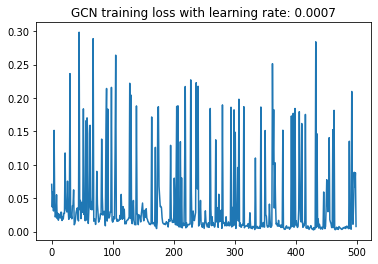

In [31]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 



g = sns.lineplot(loss_indices, losses_float)

g.set_title(f'GCN training loss with learning rate: {lr}')



In [32]:
import pandas as pd

test_preds = []
test_true = []

for test_batch in test_loader:
  test_batch = next(iter(test_loader))
  with torch.no_grad():
      test_batch.to(device)
      pred, embed = model(test_batch.pos, test_batch.edge_index, test_batch.batch) 
      pred=torch.argmax(pred,dim=1)
      test_preds.append(pred)
      test_true.append(test_batch.y)

y_pred = torch.cat(test_preds).detach().cpu().numpy()
y_true = torch.cat(test_true).detach().cpu().numpy()

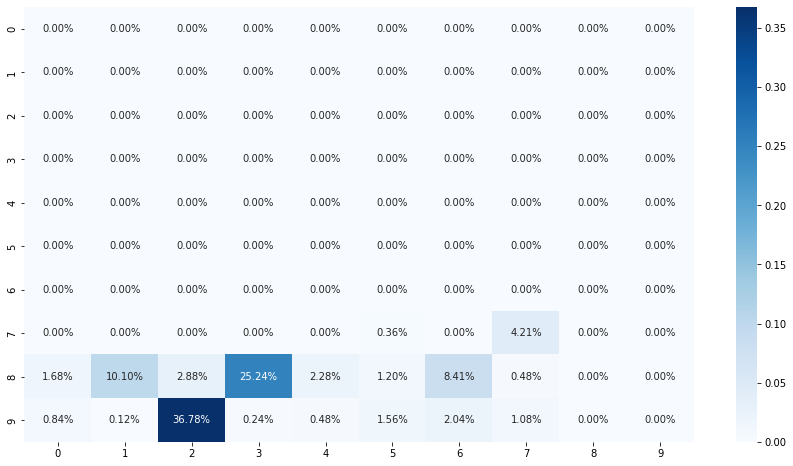

In [33]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15,8))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [34]:
classes = ['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']


In [41]:
def plot_confusionmatrix(y_train_pred,y_train,dom, classes):
    print(f'{dom} Confusion matrix')
    title = f'{dom} Confusion matrix'
    plt.figure(figsize=(15,8))
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf/np.sum(cf),annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='.2%')
    plt.title(title)
    plt.tight_layout()
    plt.show()

GCN Confusion matrix


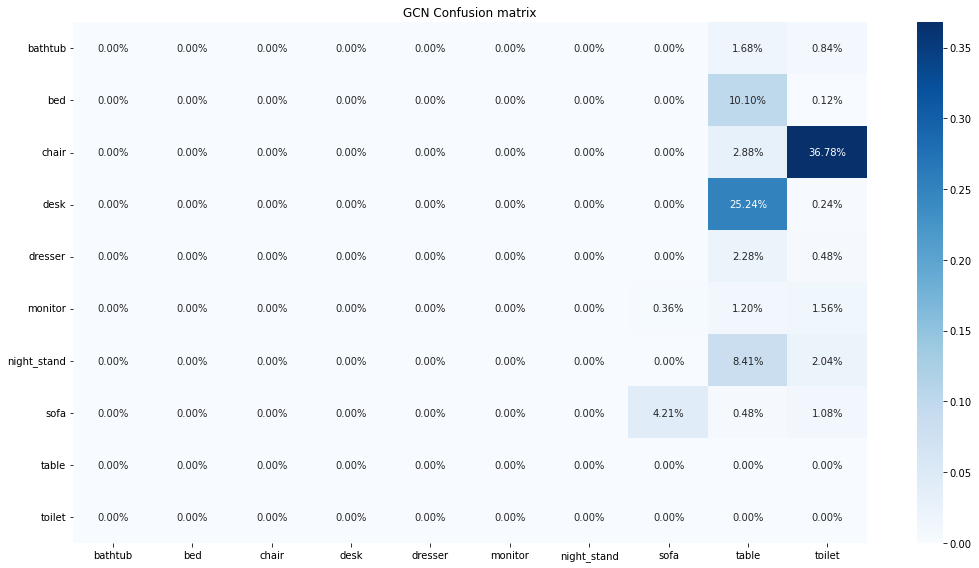

In [42]:
plot_confusionmatrix(y_pred ,y_true,'GCN',classes)

## 05 Getting Embeddings for Graph Classification Using Machine Learning 

Dimensionality reduction is achieve thru previous deep learning algorithm:
Graph representation consists of 128 features as embedding output


In [45]:

def get_embeds(model, loader):
  embeddings = []
  labels = []
  for batch in loader:
    with torch.no_grad():
        batch.to(device)
        pred, embed = model(batch.pos, batch.edge_index, batch.batch) 
        pred=torch.argmax(pred,dim=1)
        yb = batch.y
        embeddings.append(embed)
        labels.append(yb)
  return torch.cat(embeddings), torch.cat(labels)

In [46]:
embeds, labels = get_embeds(model, loader)

In [47]:
embeds.shape , labels.shape

(torch.Size([3192, 128]), torch.Size([3192]))

In [65]:
if torch.is_tensor(embeds):
  df_x = embeds.detach().cpu().numpy()
  df_y = labels.detach().cpu().numpy()

In [68]:
df_x.shape, df_y.shape

((3192, 128), (3192,))

## 06 Decision Trees

In [50]:

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from tqdm.notebook import tqdm


In [51]:
def decisiontrees(df_x, df_y, impurity):
    #impurity = 'gini' or 'entropy'
    
    max_depth_range = list(range(1, 20))
    
    results_dict = {}

    runs = 5

    test_scores = []
    acc = np.zeros([runs,len(max_depth_range)])
    times = np.zeros([runs,len(max_depth_range)])

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y)

            accuracy = []
            start_time = time.time()
            for d,depth in enumerate(max_depth_range):
                
                clf = DecisionTreeClassifier(max_depth = depth,criterion=impurity, random_state = 0)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                accuracy.append(score)
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time 
            #results_dict[depth] = {"accuracy": accuracy}
            test_scores.append(accuracy)

            pbar.update()


  
    return acc, times, clf 

In [69]:
trees_acc, times, clf = decisiontrees(df_x,df_y, 'gini')

  0%|          | 0/5 [00:00<?, ?it/s]

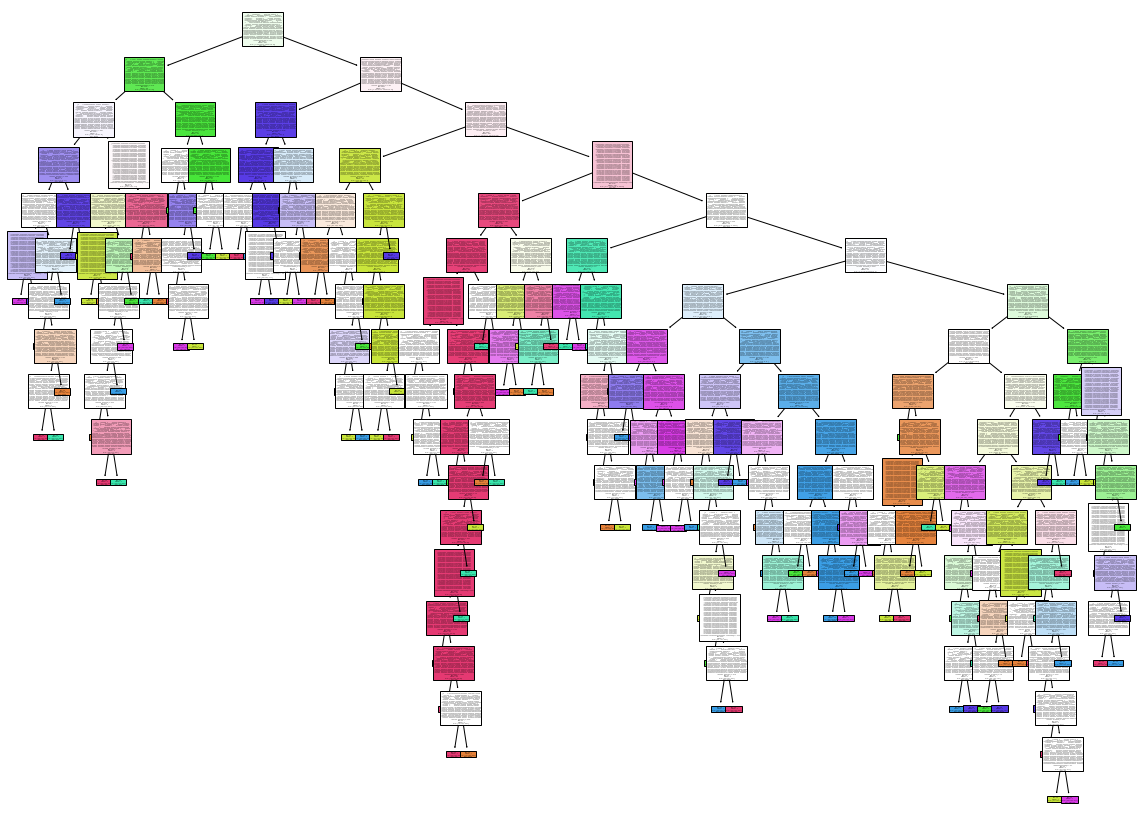

In [71]:
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix

classes = np.unique(df_y)
x = df_x
plt.figure(figsize=(20,15))
features = x
classes = ['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [72]:
max_depth_range = list(range(1, 20))

acc_plot = []
for t in trees_acc:
  for i,d in enumerate(max_depth_range):
    points = [t[i],d]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

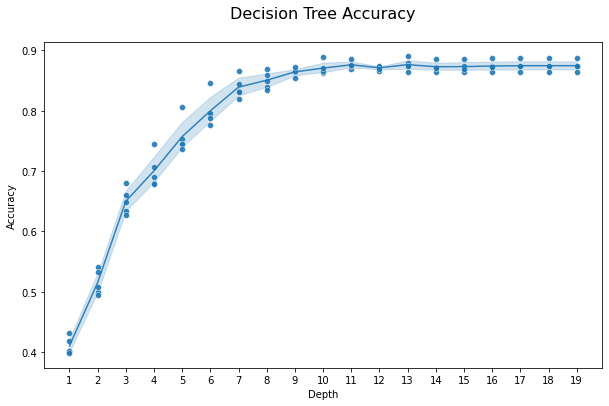

In [73]:
fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Depth")
ax.set_ylabel("Accuracy")
ax.set_title(f"Decision Tree Accuracy\n",fontsize = 16)
ax.set_xticks(max_depth_range)
ax.set_xticklabels(max_depth_range)
plt.show()

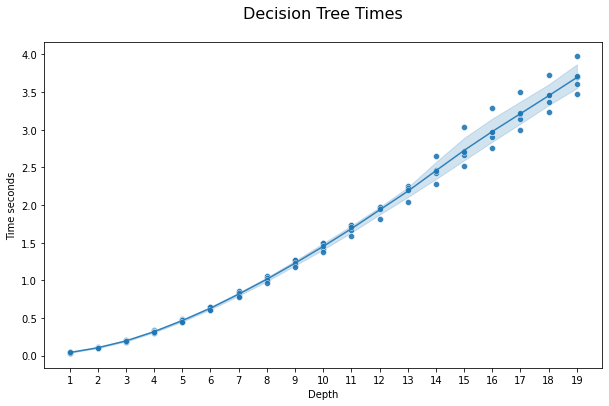

In [74]:
max_depth_range = list(range(1, 20))

t_plot = []
for t in times:
  for i,d in enumerate(max_depth_range):
    points = [t[i],d]
    t_plot.append(points)
t_plot = np.array(t_plot)
fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=t_plot[:,1],y=t_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=t_plot[:,1],y=t_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Depth")
ax.set_ylabel("Time seconds")
ax.set_title(f"Decision Tree Times\n",fontsize = 16)
ax.set_xticks(max_depth_range)
ax.set_xticklabels(max_depth_range)
plt.show()

Train score 1.0
Test score 0.8909774436090225
Train Confusion matrix


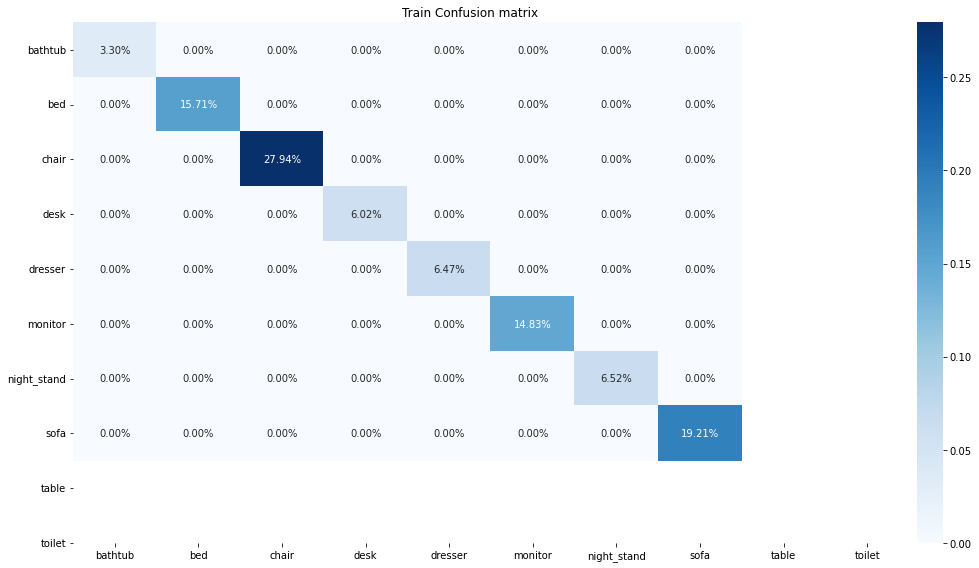

Test Confusion matrix


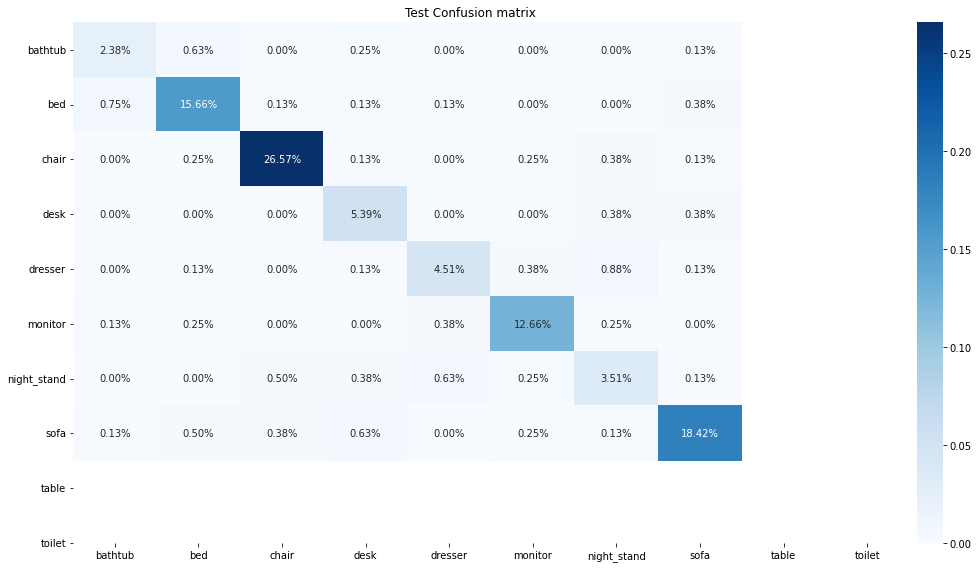

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y)
clf.fit(X_train,Y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,Y_train)}')
print(f'Test score {accuracy_score(y_test_pred,Y_test)}')
plot_confusionmatrix(y_train_pred,Y_train,dom='Train',classes=classes)
plot_confusionmatrix(y_test_pred,Y_test,dom='Test',classes=classes)

## 07 Boosting Trees

In [81]:
def boostingtrees(df_x, df_y):
    num_estimators = [10,20,50,100]
    test_scores = []
    runs = 5
    acc = np.zeros([runs,len(num_estimators)])
    times = np.zeros([runs,len(num_estimators)])
    #runs = 5

    test_scores = []

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y)
            
            accuracy = []
            start_time = time.time()
            for d,num_est in enumerate(num_estimators):
                clf = GradientBoostingClassifier(n_estimators=num_est, max_depth= 1)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                accuracy.append(score)
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time 

            test_scores.append(accuracy)

            pbar.update()
    
    return acc,times

In [82]:
acc,times = boostingtrees(df_x, df_y)

  0%|          | 0/5 [00:00<?, ?it/s]

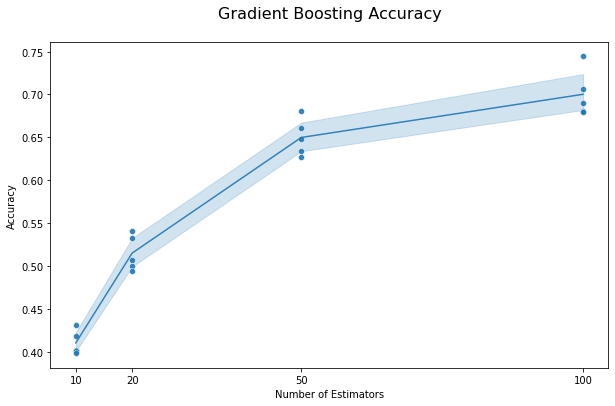

In [83]:
num_estimators = [10,20,50,100]

acc_plot = []
for t in trees_acc:
  for i,d in enumerate(num_estimators):
    points = [t[i],d]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Accuracy")
ax.set_title(f"Gradient Boosting Accuracy\n",fontsize = 16)
ax.set_xticks(num_estimators)
ax.set_xticklabels(num_estimators)
plt.show()

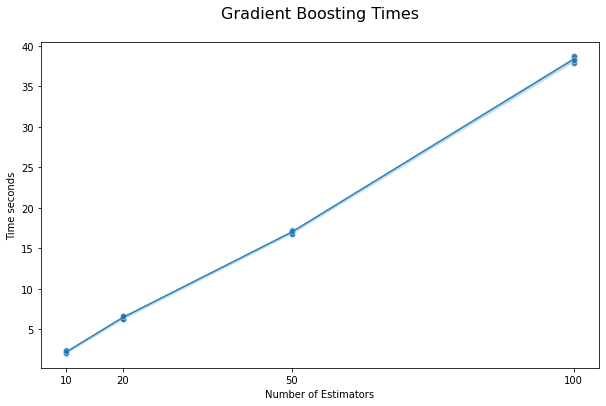

In [84]:
num_estimators = [10,20,50,100]

t_plot = []
for t in times:
  for i,d in enumerate(num_estimators):
    points = [t[i],d]
    t_plot.append(points)
t_plot = np.array(t_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=t_plot[:,1],y=t_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=t_plot[:,1],y=t_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Time seconds")
ax.set_title(f"Gradient Boosting Times\n",fontsize = 16)
ax.set_xticks(num_estimators)
ax.set_xticklabels(num_estimators)
plt.show()

## 08 KNN

In [85]:
def knn(df_x, df_y):
    num_estimators = [2, 5, 10, 20, 50, 100]

    runs = 5
    acc = np.zeros([runs,len(num_estimators)])
    times = np.zeros([runs,len(num_estimators)])

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=.20)
            
            accuracy = []
            start_time = time.time()
            for d,num_est in enumerate(num_estimators):
                
                clf = KNeighborsClassifier(n_neighbors=num_est)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                accuracy.append(score)
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time 

          

            pbar.update()
    
    return  acc,times

In [86]:
knn_acc, knn_times = knn(df_x, df_y)

  0%|          | 0/5 [00:00<?, ?it/s]

In [87]:
def create_acc_plot(params, acc, title):
  num_estimators = params

  acc_plot = []
  for t in acc:
    for i,d in enumerate(num_estimators):
      points = [t[i],d]
      acc_plot.append(points)
  acc_plot = np.array(acc_plot)
  df_acc = pd.DataFrame(acc_plot)

  fig, (ax) = plt.subplots(1,figsize=(10,6))
  sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
  sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
  ax.set_xlabel("Number of Estimators")
  ax.set_ylabel("Accuracy")
  ax.set_title(f"{title}\n",fontsize = 16)
  ax.set_xticks(num_estimators)
  ax.set_xticklabels(num_estimators)
  plt.show()

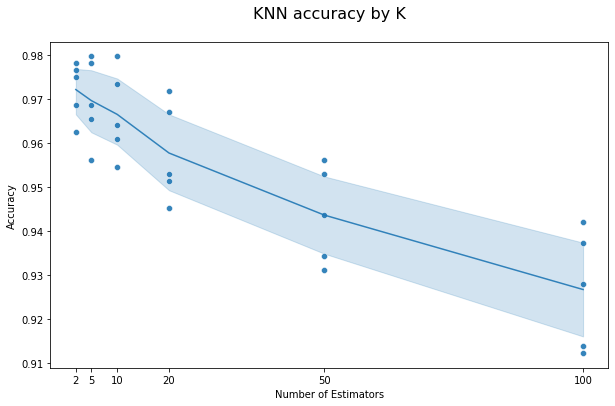

In [88]:
num_estimators = [2, 5, 10, 20, 50, 100]

create_acc_plot(num_estimators,knn_acc,"KNN accuracy by K")

In [89]:
def create_time_plot(params,array,title):
  num_estimators = params

  t_plot = []
  for t in array:
    #print(t)
    for i,d in enumerate(num_estimators):
      points = [t[i],d]
      t_plot.append(points)
  t_plot = np.array(t_plot)

  fig, (ax) = plt.subplots(1,figsize=(10,6))
  sns.lineplot(x=t_plot[:,1],y=t_plot[:,0], alpha=0.9, ax = ax)
  sns.scatterplot(x=t_plot[:,1],y=t_plot[:,0],alpha=0.9,ax=ax)
  ax.set_xlabel("Number of Estimators")
  ax.set_ylabel("Time seconds")
  ax.set_title(f"{title}\n",fontsize = 16)
  ax.set_xticks(num_estimators)
  ax.set_xticklabels(num_estimators)
  plt.show()

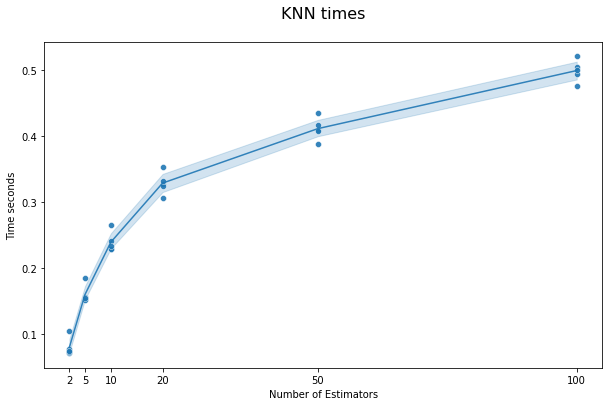

In [90]:
create_time_plot(num_estimators,knn_times,"KNN times")

## 08 SVM

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(features)
x = scaling.transform(features)

In [92]:
def svmc(x,y):
    from sklearn.svm import SVC
    num_estimators = ['linear', 'poly', 'rbf', 'sigmoid']

    runs = 5
    acc = np.zeros([runs,len(num_estimators)])
    times = np.zeros([runs,len(num_estimators)])

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(x, y)
            
            
            start_time = time.time()
            for d,num_est in enumerate(num_estimators):
                
                
                clf = SVC(kernel=num_est)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time

            

            pbar.update()
    
    return acc,times, num_estimators

In [93]:
svm_acc,svm_times, svm_num_estimators = svmc(x,df_y)

  0%|          | 0/5 [00:00<?, ?it/s]

[0.99498747 0.98997494 0.98496241 0.97994987]
[0.99874687 0.98120301 0.97994987 0.97619048]
[0.99373434 0.98370927 0.98370927 0.97493734]
[0.99373434 0.98496241 0.98245614 0.97869674]
[0.9924812  0.99373434 0.9924812  0.9887218 ]


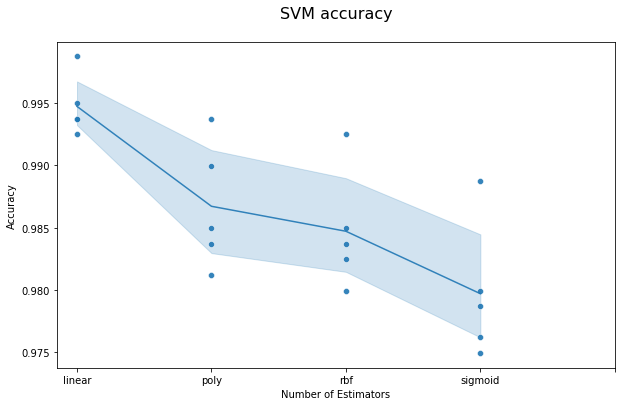

In [94]:
title = 'SVM accuracy'
num_estimators = svm_num_estimators
acc = svm_acc
acc_plot = []
set_xticks = range(0,len(num_estimators)+1)
for t in acc:
  print(t)
  for i,d in enumerate(num_estimators):
    points = [t[i],i]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))


sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Accuracy")
ax.set_title(f"{title}\n",fontsize = 16)
ax.set_xticks(set_xticks)
ax.set_xticklabels(num_estimators)
plt.show()

[0.07860184 0.17898846 0.37071943 0.64072537]
[0.07069874 0.16871858 0.35035777 0.61945295]
[0.08563662 0.19383025 0.37027121 0.6356039 ]
[0.06702733 0.16478992 0.34033108 0.6158731 ]
[0.07158709 0.17018867 0.3512392  0.61769605]


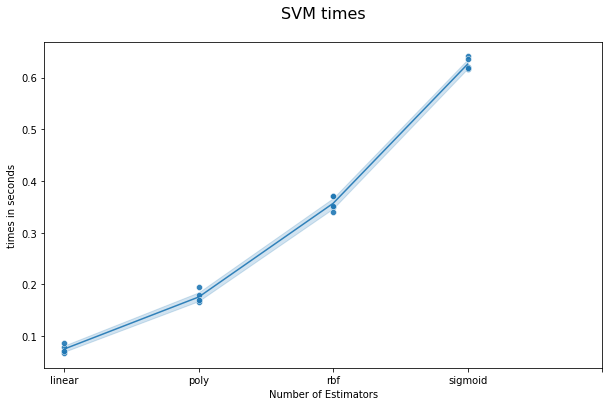

In [95]:
title = 'SVM times'
num_estimators = svm_num_estimators
acc = svm_times
acc_plot = []
set_xticks = range(0,len(num_estimators)+1)
for t in acc:
  print(t)
  for i,d in enumerate(num_estimators):
    points = [t[i],i]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))


sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("times in seconds")
ax.set_title(f"{title}\n",fontsize = 16)
ax.set_xticks(set_xticks)
ax.set_xticklabels(num_estimators)
plt.show()